<h1>Primeiros dados</h1>

In [80]:
import os
import pandas as pd

dataframes = pd.DataFrame()

base1 = pd.read_csv("D:\\CEDERJ\\2024.2\\tcc\\IVOptionPredictor\\projeto\\data\\iniciais\\strike_4a10_spot_3.5a12.2\\base_de_dados_1.csv")
results1 = pd.read_csv("D:\\CEDERJ\\2024.2\\tcc\\IVOptionPredictor\\projeto\\data\\iniciais\\strike_4a10_spot_3.5a12.2\\result_1.csv")
        
# df_result_filtrado = results1[(results1['Result'].notna()) & (results1['Result'] != -1)]
# indices_to_keep = df_result_filtrado.index
# df_inputs_filtrado = base1.loc[indices_to_keep]
# df_inputs_filtrado['Result'] = df_result_filtrado['Result']

# dataframes = pd.concat([dataframes, df_inputs_filtrado], axis = 0)

df_base1 = base1
df_base1['Result'] = results1['Result']
dataframes = pd.concat([dataframes, df_base1], axis = 0)

base2 = pd.read_csv("D:\\CEDERJ\\2024.2\\tcc\\IVOptionPredictor\\projeto\\data\\iniciais\\strike_10a15_spot_8.5a17.2\\base_de_dados_2.csv")
results2 = pd.read_csv("D:\\CEDERJ\\2024.2\\tcc\\IVOptionPredictor\\projeto\\data\\iniciais\\strike_10a15_spot_8.5a17.2\\result_2.csv")

df_base2 = base2
df_base2['Result'] = results2['Result']
dataframes = pd.concat([dataframes, df_base2], axis = 0)

base3 = pd.read_csv("D:\\CEDERJ\\2024.2\\tcc\\IVOptionPredictor\\projeto\\data\\iniciais\\strike_15a20_spot_12.5a22.5\\base_de_dados_3.csv")
results3 = pd.read_csv("D:\\CEDERJ\\2024.2\\tcc\\IVOptionPredictor\\projeto\\data\\iniciais\\strike_15a20_spot_12.5a22.5\\result_3.csv")

df_base3 = base3
df_base3['Result'] = results3['Result']
dataframes = pd.concat([dataframes, df_base3], axis = 0)

dataframes['CallPut'] = dataframes['CallPut'].replace({'call': 0, 'put': 1})

dataframes_testes = dataframes.copy()


<h1>Estudo dados - Remoção de outliers</h1>

In [156]:
import matplotlib.pyplot as plt

# df_estudo = dataframes[dataframes['Result'] <= 10]

df_estudo = dataframes[(dataframes['Result'].notna()) & (dataframes['Result'] != -1) & (dataframes['Result'] > 0)]

print("vol impl do df_estudo inferiores a 0 - " + (str)(((df_estudo[df_estudo['Result'] <= 0])).shape[0]))
print("vol impl inferiores a 5 - " + (str)(((dataframes[dataframes['Result'] <= 5])).shape[0]))

print("vol impl superior a 5 - " + (str)(((dataframes[dataframes['Result'] >= 5])).shape[0]))     
print("vol impl superior a 10 - " + (str)(((dataframes[dataframes['Result'] >= 10])).shape[0]))
print("vol impl superior a 20 - " + (str)(((dataframes[dataframes['Result'] >= 20])).shape[0]))
print("vol impl superior a 50 - " + (str)(((dataframes[dataframes['Result'] >= 50])).shape[0]))
print("vol impl superior a 100 - " + (str)(((dataframes[dataframes['Result'] >= 100])).shape[0]))

# Calcular os quartis e o IQR
Q1 = df_estudo['Result'].quantile(0.25)
Q3 = df_estudo['Result'].quantile(0.75)
IQR = Q3 - Q1

# Determinar os limites inferior e superior para outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("limite dos outliers - " + (str)(lower_bound))
print("limite dos outliers - " + (str)(upper_bound))

# df_filtrado = dataframes[dataframes['TaxaDesconto']]

print("vol impl inferiores a lowerBound - " + (str)(((df_estudo[df_estudo['Result'] <= lower_bound])).shape[0]))

print("vol impl superior a upperBound - " + (str)(((df_estudo[df_estudo['Result'] >= upper_bound])).shape[0]))  
print("-----")

df_novo_sem_outliers = dataframes[dataframes['Result'] < upper_bound]

# Q1_2 = df_sem_outliers_1['Result'].quantile(0.25)
# Q3_2 = df_sem_outliers_1['Result'].quantile(0.75)
# IQR_2 = Q3 - Q1

# # Determinar os limites inferior e superior para outliers
# lower_bound_2 = Q1_2 - 1.5 * IQR_2b        bb 
# upper_bound_2 = Q3_2 + 1.5 * IQR_2


# print("limite dos outliers_2 - " + (str)(lower_bound_2))
# print("limite dos outliers_2 - " + (str)(upper_bound_2))

# print("vol impl inferiores a lowerBound_2 - " + (str)(((df_estudo[df_estudo['Result'] <= lower_bound_2])).shape[0]))

# print("vol impl superior a upperBound_2 - " + (str)(((df_estudo[df_estudo['Result'] >= upper_bound_2])).shape[0]))  
# print("-----")

# dataframe_sem_outliers = dataframes[(dataframes['Result'].notna()) & (dataframes['Result'] != -1) & (dataframes['Result'] > 0) & (dataframes['Result'] < upper_bound_2)]


# # Identificar os outliers
# outliers = df_estudo[(df_estudo['Result'] < lower_bound) | (df_estudo['Result'] > upper_bound)]

# # Valor máximo determinado como outlier
# max_outlier = outliers['Result'].max()

# # Plotar boxplot para visualização dos outliers
# plt.figure(figsize=(10, 6))
# plt.boxplot(df_estudo['Result'], vert=False)
# plt.title('Boxplot dos valores de Result com Outliers')
# plt.xlabel('Valores de Result')
# plt.grid(True)
# plt.show()

# # Plotar os outliers em um scatter plot
# plt.figure(figsize=(10, 6))
# plt.scatter(outliers.index, outliers['Result'], color='r', label='Outliers')
# plt.plot(df_estudo.index, df_estudo['Result'], linestyle='-', alpha=0.5, label='Valores de Result')
# plt.title('Outliers identificados no campo Result')
# plt.xlabel('Índice')
# plt.ylabel('Valores de Result')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Valor máximo determinado como outlier
# max_outlier


vol impl do df_estudo inferiores a 0 - 0
vol impl inferiores a 5 - 5668080
vol impl superior a 5 - 19388
vol impl superior a 10 - 6474
vol impl superior a 20 - 5235
vol impl superior a 50 - 4783
vol impl superior a 100 - 4478
limite dos outliers - -0.4593854220579583
limite dos outliers - 2.211926090524117
vol impl inferiores a lowerBound - 0
vol impl superior a upperBound - 195852
-----
limite dos outliers_2 - -2.0017418172182784
limite dos outliers_2 - 2.006056214184988
vol impl inferiores a lowerBound_2 - 0
vol impl superior a upperBound_2 - 260700
-----


<h1>Novos dados - redução nos valores do premios</h1>

In [1]:
import os
import pandas as pd

dataframes = pd.DataFrame()

base1 = pd.read_csv("D:\\CEDERJ\\2024.2\\tcc\\IVOptionPredictor\\projeto\\data\\iniciais\\novos_premios\\strike_5a10\\strike_5a10.csv")
results1 = pd.read_csv("D:\\CEDERJ\\2024.2\\tcc\\IVOptionPredictor\\projeto\\data\\iniciais\\novos_premios\\strike_5a10\\result.csv")

df_base1 = base1
df_base1['Result'] = results1['Result']
dataframes = pd.concat([dataframes, df_base1], axis = 0)

base2 = pd.read_csv("D:\\CEDERJ\\2024.2\\tcc\\IVOptionPredictor\\projeto\\data\\iniciais\\novos_premios\\strike_10a15\\strike_10a15.csv")
results2 = pd.read_csv("D:\\CEDERJ\\2024.2\\tcc\\IVOptionPredictor\\projeto\\data\\iniciais\\novos_premios\\strike_10a15\\result.csv")

df_base2 = base2
df_base2['Result'] = results2['Result']
dataframes = pd.concat([dataframes, df_base2], axis = 0)

base3 = pd.read_csv("D:\\CEDERJ\\2024.2\\tcc\\IVOptionPredictor\\projeto\\data\\iniciais\\novos_premios\\strike_15a20\\strike_15a20.csv")
results3 = pd.read_csv("D:\\CEDERJ\\2024.2\\tcc\\IVOptionPredictor\\projeto\\data\\iniciais\\novos_premios\\strike_15a20\\result.csv")

df_base3 = base3
df_base3['Result'] = results3['Result']
dataframes = pd.concat([dataframes, df_base3], axis = 0)

base4 = pd.read_csv("D:\\CEDERJ\\2024.2\\tcc\\IVOptionPredictor\\projeto\\data\\iniciais\\novos_premios\\strike_20a25\\strike_20a25.csv")
results4 = pd.read_csv("D:\\CEDERJ\\2024.2\\tcc\\IVOptionPredictor\\projeto\\data\\iniciais\\novos_premios\\strike_20a25\\result.csv")

df_base4 = base4
df_base4['Result'] = results4['Result']
dataframes = pd.concat([dataframes, df_base4], axis = 0)

dataframes['CallPut'] = dataframes['CallPut'].replace({'call': 0, 'put': 1})

dataframes_novos_dados = dataframes.copy()

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_9296\126048534.py:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataframes['CallPut'] = dataframes['CallPut'].replace({'call': 0, 'put': 1})


In [5]:
dataframes_novos_dados.shape[0]

4195200

In [4]:
df_valido = dataframes_novos_dados[(dataframes_novos_dados['Result'].notna()) & (dataframes_novos_dados['Result'] != -1) & (dataframes_novos_dados['Result'] > 0)]

df_valido.shape[0]

1670381

<h1>Estudo dos dados - novos premios - remoção de outliers</h1>

In [10]:
dataframes_novos_dados.shape[0]

4195200

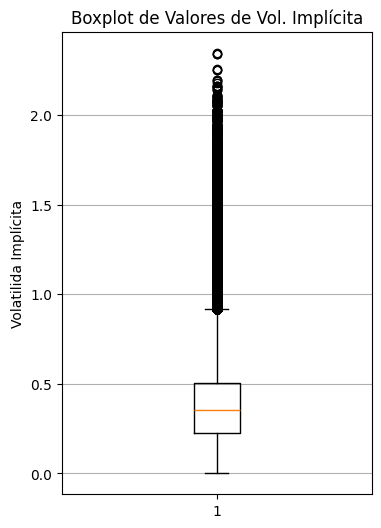

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

df_estudo_boxplot = dataframes_novos_dados[(dataframes_novos_dados['Result'].notna()) & (dataframes_novos_dados['Result'] != -1) & (dataframes_novos_dados['Result'] > 0)]

# Plotando o boxplot da coluna 'Result'
plt.figure(figsize=(4, 6))
plt.boxplot(df_estudo_boxplot['Result'])
plt.title('Boxplot de Valores de Vol. Implícita')
plt.ylabel('Volatilida Implícita')
plt.xlabel('')
plt.grid(axis='y')

# Exibindo o gráfico
plt.show()


In [6]:
import matplotlib.pyplot as plt

# df_estudo = dataframes_novos_dados[dataframes_novos_dados['Result'] <= 10]

df_estudo = dataframes_novos_dados[(dataframes_novos_dados['Result'].notna()) & (dataframes_novos_dados['Result'] != -1) & (dataframes_novos_dados['Result'] > 0)]

print("vol impl do df_estudo inferiores a 0 - " + (str)(((df_estudo[df_estudo['Result'] <= 0])).shape[0]))
print("vol impl inferiores a 5 - " + (str)(((dataframes_novos_dados[dataframes_novos_dados['Result'] <= 5])).shape[0]))

print("vol impl superior a 5 - " + (str)(((dataframes_novos_dados[dataframes_novos_dados['Result'] >= 5])).shape[0]))     
print("vol impl superior a 10 - " + (str)(((dataframes_novos_dados[dataframes_novos_dados['Result'] >= 10])).shape[0]))
print("vol impl superior a 20 - " + (str)(((dataframes_novos_dados[dataframes_novos_dados['Result'] >= 20])).shape[0]))
print("vol impl superior a 50 - " + (str)(((dataframes_novos_dados[dataframes_novos_dados['Result'] >= 50])).shape[0]))
print("vol impl superior a 100 - " + (str)(((dataframes_novos_dados[dataframes_novos_dados['Result'] >= 100])).shape[0]))

# Calcular os quartis e o IQR
Q1 = df_estudo['Result'].quantile(0.25)
Q3 = df_estudo['Result'].quantile(0.75)
IQR = Q3 - Q1

# Determinar os limites inferior e superior para outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("limite dos outliers - " + (str)(lower_bound))
print("limite dos outliers - " + (str)(upper_bound))

# df_filtrado = dataframes_novos_dados[dataframes_novos_dados['TaxaDesconto']]

print("vol impl inferiores a lowerBound - " + (str)(((df_estudo[df_estudo['Result'] <= lower_bound])).shape[0]))

print("vol impl superior a upperBound - " + (str)(((df_estudo[df_estudo['Result'] >= upper_bound])).shape[0]))  
print("-----")

df_novo_sem_outliers_1 = dataframes_novos_dados[dataframes_novos_dados['Result'] < upper_bound]

print("quantidade final - " + str(df_novo_sem_outliers_1.shape[0]))

vol impl do df_estudo inferiores a 0 - 0
vol impl inferiores a 5 - 4195200
vol impl superior a 5 - 0
vol impl superior a 10 - 0
vol impl superior a 20 - 0
vol impl superior a 50 - 0
vol impl superior a 100 - 0
limite dos outliers - -0.1879640679186795
limite dos outliers - 0.9170105345115741
vol impl inferiores a lowerBound - 0
vol impl superior a upperBound - 35833
-----
quantidade final - 4159367


<h1>Filtrando dataframe para execução do grid search</h1>

In [2]:
print(dataframes_novos_dados.shape[0])

df_filtrado = dataframes_novos_dados[(dataframes_novos_dados['Result'].notna()) & (dataframes_novos_dados['Result'] != -1) & (dataframes_novos_dados['Result'] > 0)]
print(df_filtrado.shape[0])
df_filtrado = dataframes_novos_dados[dataframes_novos_dados['TaxaDesconto'].isin([0.08, 0.09, 0.1])]
print(df_filtrado.shape[0])
df_filtrado = df_filtrado[df_filtrado['Maturity'].isin([0.2, 0.3, 0.4])]
print(df_filtrado.shape[0])
# df_filtrado = df_filtrado[df_filtrado['CallPut'].isin([0])]
# print(df_filtrado.shape[0])

df_filtrado = df_filtrado[(df_filtrado['Spot'] >= 9.5) & (df_filtrado['Spot'] <= 13)]
# print(df_filtrado.shape[0])

dataframe_sem_outliers_filtrado = df_filtrado
print(dataframe_sem_outliers_filtrado.shape[0])
dataframe_gridSearch = dataframe_sem_outliers_filtrado.copy()

4195200
1670381
2796800
2097600
345000


In [2]:
import pandas as pd

df_filtrado = dataframes_novos_dados[(dataframes_novos_dados['Result'].notna()) & (dataframes_novos_dados['Result'] != -1) & (dataframes_novos_dados['Result'] > 0)]

# Selecionando 400000 registros aleatórios do dataframe existente
dataframe_para_gridsearch = df_filtrado.sample(n=400000, random_state=42)

# Verificando o novo dataframe
print(dataframe_para_gridsearch.head())


         Unnamed: 0  Strike  Maturity  Spot  TaxaDesconto  Premio  CallPut  \
1038082     1038082    19.5       0.4  17.5          0.10    0.05        0   
901940       901940    23.4       0.4  17.5          0.11    0.50        0   
559485       559485    12.8       0.4  15.8          0.09    0.85        1   
781133       781133    14.0       0.2  14.8          0.10    0.20        1   
637819       637819    17.8       0.1  20.0          0.11    0.75        1   

           Result  
1038082  0.086329  
901940   0.420400  
559485   0.612187  
781133   0.231413  
637819   0.712271  


<h1>Execução do grid search</h1>

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

dataframe_gridSearch_limpo = dataframe_para_gridsearch[(dataframe_para_gridsearch['Result'].notna()) & (dataframe_para_gridsearch['Result'] != -1)]

# Dados de entrada e variável alvo
dataframe_gridSearch_limpo['Spot/Strike'] = dataframe_gridSearch_limpo['Spot']/dataframe_gridSearch_limpo['Strike']

X = dataframe_gridSearch_limpo[['Spot/Strike', 'Maturity', 'TaxaDesconto', 'Premio', 'CallPut']].values
y = dataframe_gridSearch_limpo['Result'].values

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Definir o pipeline
pipeline = Pipeline([ # Normalizar os dados
    ('model', LinearRegression())  # Placeholder para o modelo, será substituído
])

# Dicionário com modelos e seus hiperparâmetros
param_grid = [
    {
        'model': [RandomForestRegressor()],
        'model__n_estimators': [100, 200, 300, 400],
        'model__max_depth': [None, 10],
        'model__min_samples_split': [2, 10],
        'model__min_samples_leaf': [1, 2],
        'model__max_features': [None, 'sqrt', 'log2'],
        'model__bootstrap': [True, False]
    }
]

# GridSearchCV para encontrar o melhor modelo e hiperparâmetros
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# Ajuste do GridSearch com os dados de treino
grid_search.fit(X_train, y_train)

# Melhor modelo encontrado
best_model = grid_search.best_estimator_

print("Melhor modelo e hiperparâmetros:", grid_search.best_params_)

# Avaliação no conjunto de teste
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE no conjunto de teste: {mse}")
print(f"R² no conjunto de teste: {r2}")

d:\CEDERJ\2024.2\tcc\IVOptionPredictor\myenv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
50 fits failed out of a total of 576.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "d:\CEDERJ\2024.2\tcc\IVOptionPredictor\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\CEDERJ\2024.2\tcc\IVOptionPredictor\myenv\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\CEDERJ\2024.2\tcc\IVOptionPredictor\myenv\Lib\s

Melhor modelo e hiperparâmetros: {'model': RandomForestRegressor(), 'model__bootstrap': True, 'model__max_depth': None, 'model__max_features': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10, 'model__n_estimators': 400}
MSE no conjunto de teste: 0.014414265365131924
R² no conjunto de teste: 0.689901681901238


<h1>Treinamento do modelo random forest</h1>

In [12]:
#### LIMPEZA DOS DADOS
dataframes_RF = dataframes_novos_dados.copy()

df_result_filtrado = dataframes_RF[(dataframes_RF['Result'].notna()) & (dataframes_RF['Result'] != -1)]
# indices_to_keep = df_result_filtrado.index
# df_inputs_filtrado = base3.loc[indices_to_keep]
# df_inputs_filtrado['Result'] = df_result_filtrado['Result']

<h3>montagem dataset treino</h3>

In [13]:
df_result_filtrado['Str/Spot'] = df_result_filtrado['Strike']/df_result_filtrado['Spot']

X = df_result_filtrado[['Str/Spot', 'Maturity', 'TaxaDesconto', 'Premio', 'CallPut']].values
y = df_result_filtrado['Result'].values
print(df_result_filtrado.shape[0])
X_train_RF, X_test_RF, y_train_RF, y_test_RF = train_test_split(X, y, test_size=0.3, random_state=42)

# scaler_X_RF = StandardScaler()
# scaler_y_RF = StandardScaler()
# model_RF = RandomForestRegressor()

# Ajustar e transformar os dados de treino
# X_train_scaled_RF = scaler_X_RF.fit_transform(X_train_RF)
# y_train_scaled_RF = scaler_y_RF.fit_transform(y_train_RF.reshape(-1, 1))

# X_test_scaled_RF = scaler_X_RF.fit_transform(X_test_RF)

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_32344\1972460305.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result_filtrado['Str/Spot'] = df_result_filtrado['Strike']/df_result_filtrado['Spot']


1670391


In [14]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

rf_model = RandomForestRegressor(
    max_depth=None,
    min_samples_leaf=1,
    max_features='sqrt',
    min_samples_split=2, 
    n_estimators=100,
    random_state=42
)

# Definir o KFold para a validação cruzada
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Usar cross_val_score para calcular o MSE e R² em cada dobra
# mse_scorer_RF = make_scorer(mean_squared_error, greater_is_better=False)
# r2_scorer_RF = make_scorer(r2_score)

# mse_scores_RF = cross_val_score(rf_model, X_train_scaled_RF, y_train_scaled_RF, cv=kf, scoring=mse_scorer_RF)
# r2_scores_RF = cross_val_score(rf_model, X_train_scaled_RF, y_train_scaled_RF, cv=kf, scoring=r2_scorer_RF)

# Ajustar o modelo aos dados de treino
rf_model.fit(X_train_RF, y_train_RF)

# Fazer previsões no conjunto de teste
y_pred_RF = rf_model.predict(X_test_RF)
# y_pred_RF = scaler_y_RF.inverse_transform(y_pred_RF_scaled.reshape(-1, 1))

# Avaliar o modelo no conjunto de teste
mse_test_RF = mean_squared_error(y_test_RF, y_pred_RF)
r2_test_RF = r2_score(y_test_RF, y_pred_RF)

# Resultados da validação cruzada e do conjunto de teste
# print(f"MSE médio (validação cruzada): {-np.mean(mse_scores_RF)}")
# print(f"R² médio (validação cruzada): {np.mean(r2_scores_RF)}")
print(f"MSE no conjunto de teste: {mse_test_RF}")
print(f"R² no conjunto de teste: {r2_test_RF}")


MSE no conjunto de teste: 0.02120402556375423
R² no conjunto de teste: 0.5460479999578838


In [33]:
### salvando o modelo
#################### pip install joblib

from joblib import dump

# Supondo que 'best_model' seja o modelo treinado (por exemplo, após o GridSearchCV)
dump(rf_model, 'random_forest_treinado_ajuste_strike_sobrs_spot.joblib')


['random_forest_treinado.joblib']

In [ ]:
## carregando modelo

from joblib import load

# Carregar o modelo salvo
modelo_carregado = load('random_forest_treinado_ajuste_strike_sobrs_spot.joblib')

# Usar o modelo carregado para fazer previsões
####### predicoes = modelo_carregado.predict(X_novo)


<h1>Estudo do modelo Random Rorest Regressor</h1>

In [41]:
import matplotlib.pyplot as plt
import pandas as pd
df_RF_estudo = dataframes_novos_dados.copy()

df_result_filtrado_RF = df_RF_estudo[(df_RF_estudo['Result'].notna()) & (df_RF_estudo['Result'] != -1)]

df_estudo_vencimento = df_result_filtrado_RF[(df_result_filtrado_RF['Maturity'] == 0.2) & (df_result_filtrado_RF['TaxaDesconto'] == 0.09) & (df_result_filtrado_RF['Spot'] == 11)]
# print(df_estudo_vencimento)
dados_x_RF = df_estudo_vencimento[['Strike', 'Maturity', 'Spot', 'TaxaDesconto', 'Premio', 'CallPut']].values
# print(df_estudo_vencimento[['Result']].values[10:15])
# dados_x_RF_scaled = scaler_X_RF.fit_transform(dados_x_RF)

y_pred_estudo_RF = rf_model.predict(dados_x_RF)

# y_estudo_reescalado = scaler_y_RF.inverse_transform(y_pred_estudo_RF.reshape(-1, 1))

print(y_pred_estudo_RF[20])
print(y_pred_estudo_RF[21])
print(y_pred_estudo_RF[22])
print(y_pred_estudo_RF[23])
print(y_pred_estudo_RF[24])
print(y_pred_estudo_RF[25])
print(y_pred_estudo_RF[26])

print("------")

print(df_estudo_vencimento[20:27])

0.5986511811528638
0.312423343874996
0.37206446401414617
0.42599978724162596
0.46472081199409454
0.5098586378848359
0.5540094057068596
------
        Unnamed: 0  Strike  Maturity  Spot  TaxaDesconto  Premio  CallPut  \
664069      664069     9.1       0.2  11.0          0.09    0.35        1   
680065      680065     9.2       0.2  11.0          0.09    0.05        1   
680067      680067     9.2       0.2  11.0          0.09    0.10        1   
680069      680069     9.2       0.2  11.0          0.09    0.15        1   
680071      680071     9.2       0.2  11.0          0.09    0.20        1   
680073      680073     9.2       0.2  11.0          0.09    0.25        1   
680075      680075     9.2       0.2  11.0          0.09    0.30        1   

          Result  
664069  0.612911  
680065  0.312259  
680067  0.376254  
680069  0.427672  
680071  0.473206  
680073  0.515246  
680075  0.554952  


In [99]:
df = pd.DataFrame(y_estudo_reescalado)
df.to_csv("resultados.csv")

<h1>grid search do modelo sgboost</h1>

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Dados de entrada e variável alvo
X = dataframe_para_gridsearch[['Strike', 'Maturity', 'Spot', 'TaxaDesconto', 'Premio', 'CallPut']].values
y = dataframe_para_gridsearch['Result'].values

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Definir o pipeline
pipeline2 = Pipeline([  
    ('model', XGBRegressor())  # Substituir o modelo pelo XGBRegressor
])

# Dicionário com hiperparâmetros para o XGBoost
param_grid2 = {
    # 'model__n_estimators': [50, 100],
    # 'model__max_depth': [None, 10, 5],
    # 'model__learning_rate': [0.01, 0.1],
    # 'model__subsample': [0.8, 1.0]
    # 'model__n_estimators': [100, 150, 200],
    # 'model__max_depth': [10, 15],
    # 'model__learning_rate': [0.1, 0.15],
    # 'model__subsample': [0.7, 0.8],
    # 'model__colsample_bytree': [0.6, 0.8, 1.0],
    # 'model__gamma': [0, 0.1, 0.2],
    # 'model__reg_alpha': [0, 0.1, 0.5],
    # 'model__reg_lambda': [1, 1.5, 2],
    'model__n_estimators': [300, 350, 400],
    'model__max_depth': [15],
    'model__learning_rate': [0.1],
    'model__subsample': [0.3, 0.4, 0.5],
    'model__colsample_bytree': [1.0, 1.2, 1.4],
    'model__gamma': [0],
    'model__reg_alpha': [0],
    'model__reg_lambda': [3, 3.5]
}

# GridSearchCV para encontrar o melhor modelo e hiperparâmetros
grid_search2 = GridSearchCV(pipeline2, param_grid2, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Ajuste do GridSearch com os dados de treino
grid_search2.fit(X_train, y_train)

# Melhor modelo encontrado
best_model2 = grid_search2.best_estimator_

print("Melhor modelo e hiperparâmetros:", grid_search2.best_params_)

# Avaliação no conjunto de teste
y_pred = best_model2.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE no conjunto de teste: {mse}")
print(f"R² no conjunto de teste: {r2}")

# Exemplo de previsão com o melhor modelo
# new_data = np.array([[strike, maturity, spot, taxa_desconto, premio, callput]])
# predicted_vol = best_model.predict(new_data)
# print(f"Volatilidade implícita estimada: {predicted_vol}")


d:\CEDERJ\2024.2\tcc\IVOptionPredictor\myenv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
180 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "d:\CEDERJ\2024.2\tcc\IVOptionPredictor\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\CEDERJ\2024.2\tcc\IVOptionPredictor\myenv\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\CEDERJ\2024.2\tcc\IVOptionPredictor\myenv\Lib\

Melhor modelo e hiperparâmetros: {'model__colsample_bytree': 1.0, 'model__gamma': 0, 'model__learning_rate': 0.1, 'model__max_depth': 15, 'model__n_estimators': 400, 'model__reg_alpha': 0, 'model__reg_lambda': 3.5, 'model__subsample': 0.5}
MSE no conjunto de teste: 0.00013718509614269863
R² no conjunto de teste: 0.9970486967941513


<h1>Treinamento do sgboost</h1>

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

dataframes_boost = dataframes_novos_dados.copy()
dataframes_novos_dados
df_boost = dataframes_boost[(dataframes_boost['Result'].notna()) & (dataframes_boost['Result'] != -1)]

# Dados de entrada e variável alvo
X = df_boost[['Strike', 'Maturity', 'Spot', 'TaxaDesconto', 'Premio', 'CallPut']].values
y = df_boost['Result'].values

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Definir o pipeline com StandardScaler e XGBRegressor
pipeline_sgboost = Pipeline([  # Normalizar os dados
    ('model', XGBRegressor(
        colsample_bytree=1.0,
        gamma=0,
        learning_rate=0.1,
        max_depth=15,
        n_estimators=400,
        reg_alpha=0,
        reg_lambda=3.5,
        subsample=0.5
    ))  # Utilizando os hiperparâmetros fornecidos
])
# Melhor modelo e hiperparâmetros: {'model__colsample_bytree': 1.0, 'model__gamma': 0, 
# 'model__learning_rate': 0.1, 'model__max_depth': 15, 'model__n_estimators': 400,
#  'model__reg_alpha': 0, 'model__reg_lambda': 3.5, 'model__subsample': 0.5}

# Definir o KFold para a validação cruzada
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # Usar cross_val_score para calcular o MSE e R² em cada dobra
# mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
# r2_scorer = make_scorer(r2_score)

# mse_scores = cross_val_score(pipeline_sgboost, X_train, y_train, cv=kf, scoring=mse_scorer)
# r2_scores = cross_val_score(pipeline_sgboost, X_train, y_train, cv=kf, scoring=r2_scorer)

# Treinar o modelo com os dados de treino
pipeline_sgboost.fit(X_train, y_train)

# Avaliação do modelo no conjunto de teste
y_pred = pipeline_sgboost.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE no conjunto de teste: {mse}")
print(f"R² no conjunto de teste: {r2}")

# Exemplo de previsão com o melhor modelo
# new_data = np.array([[strike, maturity, spot, taxa_desconto, premio, callput]])
# predicted_vol = pipeline.predict(new_data)
# print(f"Volatilidade implícita estimada: {predicted_vol}")


MSE no conjunto de teste: 3.365166935563625e-05
R² no conjunto de teste: 0.9992795593193936


In [8]:
### salvando o modelo
#################### pip install joblib

from joblib import dump

# Supondo que 'best_model' seja o modelo treinado (por exemplo, após o GridSearchCV)
dump(pipeline_sgboost, 'boost_treinado_ajuste_strike_sobrs_spot.joblib')

['boost_treinado.joblib']

In [9]:
## carregando modelo

from joblib import load

# Carregar o modelo salvo
modelo_boost_carregado = load('boost_treinado_ajuste_strike_sobrs_spot.joblib')

# Usar o modelo carregado para fazer previsões
####### predicoes = modelo_carregado.predict(X_novo)

<h1>Estudo do modelo sgboost</h1>

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
df_estudo_boost = dataframes_novos_dados.copy()

df_result_filtrado_boost = df_estudo_boost[(df_estudo_boost['Result'].notna()) & (df_estudo_boost['Result'] != -1)]

df_estudo_vencimento = df_result_filtrado_boost[(df_result_filtrado_boost['Maturity'] == 0.2) & (df_result_filtrado_boost['TaxaDesconto'] == 0.09) & (df_result_filtrado_boost['Spot'] == 11)]
# print(df_estudo_vencimento)
dados_x_boost = df_estudo_vencimento[['Strike', 'Maturity', 'Spot', 'TaxaDesconto', 'Premio', 'CallPut']].values
# print(df_estudo_vencimento[['Result']].values[10:15])
# dados_x_boost_scaled = scaler_X_boost.fit_transform(dados_x_boost)

y_pred_estudo_boost = modelo_boost_carregado.predict(dados_x_boost)

# y_estudo_reescalado = scaler_y_boost.inverse_transform(y_pred_estudo_boost.reshape(-1, 1))

print(y_pred_estudo_boost[20])
print(y_pred_estudo_boost[21])
print(y_pred_estudo_boost[22])
print(y_pred_estudo_boost[23])
print(y_pred_estudo_boost[24])
print(y_pred_estudo_boost[25])
print(y_pred_estudo_boost[26])

print("------")

print(df_estudo_vencimento[20:27])

0.6110981
0.31246638
0.37613168
0.42771056
0.4667393
0.5146922
0.5569345
------
        Unnamed: 0  Strike  Maturity  Spot  TaxaDesconto  Premio  CallPut  \
664069      664069     9.1       0.2  11.0          0.09    0.35        1   
680065      680065     9.2       0.2  11.0          0.09    0.05        1   
680067      680067     9.2       0.2  11.0          0.09    0.10        1   
680069      680069     9.2       0.2  11.0          0.09    0.15        1   
680071      680071     9.2       0.2  11.0          0.09    0.20        1   
680073      680073     9.2       0.2  11.0          0.09    0.25        1   
680075      680075     9.2       0.2  11.0          0.09    0.30        1   

          Result  
664069  0.612911  
680065  0.312259  
680067  0.376254  
680069  0.427672  
680071  0.473206  
680073  0.515246  
680075  0.554952  


<h1>Rede Neural</h1>

<h3>Grid search</h3>

In [6]:
from scikeras.wrappers import KerasRegressor  # Use scikeras para integrar Keras com scikit-learn
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

dataframe_gridSearch_limpo = dataframe_para_gridsearch[(dataframe_para_gridsearch['Result'].notna()) & (dataframe_para_gridsearch['Result'] != -1)]
X_redeNeural = dataframe_gridSearch_limpo[['Strike', 'Maturity', 'Spot', 'TaxaDesconto', 'Premio', 'CallPut']].values
y_redeNeural = dataframe_gridSearch_limpo['Result'].values

X_train_redeNeural, X_test_redeNeural, y_train_redeNeural, y_test_redeNeural = train_test_split(X_redeNeural, y_redeNeural, test_size=0.3, random_state=42)

# Função para criar o modelo com os hiperparâmetros como entrada
def create_model(neurons=100, activation='relu', hidden_layers=1, init='uniform', learning_rate=1e-3, dropout_rate=0.0):
    model = Sequential()
    model.add(Dense(neurons, input_dim=input_dim, kernel_initializer=init, activation=activation))
    model.add(Dropout(dropout_rate))
    
    # Adicionar camadas ocultas adicionais, se necessário
    for _ in range(hidden_layers - 1):
        model.add(Dense(neurons, kernel_initializer=init, activation=activation))
        model.add(Dropout(dropout_rate))
    
    # Camada de saída (ajustar para seu problema)
    model.add(Dense(1, kernel_initializer=init))
    
    # Compilar o modelo
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer)
    return model

# Definir input_dim com base no seu conjunto de dados
input_dim = X_train_redeNeural.shape[1]  # ajuste 'X_train' conforme necessário

# Wrapping the Keras model for use with scikit-learn
model = KerasRegressor(model=create_model, verbose=0)
# Hiperparâmetros para o Grid Search
param_grid = {  
    # 'model__neurons': [20, 50, 100, 200, 300],
    # 'model__neurons': [20, 50, 100],
    'model__neurons': [200],
    # 'model__activation': ['relu', 'tanh'],
    'model__activation': ['tanh','relu'],
    # 'model__hidden_layers': [1, 2, 3],
    'model__hidden_layers': [2, 5, 4],
    # 'model__init': ['uniform', 'he_uniform'],
    'model__init': ['uniform'],
    # 'model__learning_rate': [1e-2, 1e-3, 1e-4, 1e-5],
    'model__learning_rate': [1e-3],
    'model__dropout_rate': [0],
    # 'batch_size': [128, 256, 512],
    'batch_size': [128],
    'epochs':   [50]
}

# Executar o Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=4)
grid_result = grid.fit(X_train_redeNeural, y_train_redeNeural)

best_model3 = grid_result.best_estimator_

print("Melhor modelo e hiperparâmetros:", grid_result.best_params_)

# Avaliação no conjunto de teste
y_pred_redeNeural = best_model3.predict(X_test_redeNeural)
mse = mean_squared_error(y_test_redeNeural, y_pred_redeNeural)
r2 = r2_score(y_test_redeNeural, y_pred_redeNeural)

print(f"MSE no conjunto de teste: {mse}")
print(f"R² no conjunto de teste: {r2}")


Fitting 3 folds for each of 6 candidates, totalling 18 fits


d:\CEDERJ\2024.2\tcc\IVOptionPredictor\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Melhor modelo e hiperparâmetros: {'batch_size': 128, 'epochs': 50, 'model__activation': 'relu', 'model__dropout_rate': 0, 'model__hidden_layers': 2, 'model__init': 'uniform', 'model__learning_rate': 0.001, 'model__neurons': 200}
MSE no conjunto de teste: 2.5052116257904623e-05
R² no conjunto de teste: 0.9994610464758625


<h1>Treinamento Rede Neural</h1>

In [10]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection  import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Função para criar o model_redeneuralo com os melhores hiperparâmetros
def create_best_model_redeneural():
    model_redeneural = Sequential()
    
    # Primeira camada oculta com 200 neurônios, 'relu' como ativação e 'uniform' como inicializador
    model_redeneural.add(Dense(200, input_dim=input_dim, kernel_initializer='uniform', activation='relu'))
    model_redeneural.add(Dropout(0))  # Taxa de dropout 0
    
    # Segunda camada oculta (configurada com 2 camadas ocultas no total)
    model_redeneural.add(Dense(200, kernel_initializer='uniform', activation='relu'))
    model_redeneural.add(Dropout(0))  # Outra camada Dropout com taxa 0
    
    # Camada de saída
    model_redeneural.add(Dense(1, kernel_initializer='uniform'))
    
    # Compilar o model_redeneuralo com otimizador Adam e taxa de aprendizado de 0.001
    optimizer = Adam(learning_rate=0.001)
    model_redeneural.compile(loss='mse', optimizer=optimizer)
    
    return model_redeneural

# Definir input_dim com base no seu conjunto de dados
input_dim = X_train_redeNeural.shape[1]

# Criar o model_redeneuralo com os melhores hiperparâmetros
model_redeneural = create_best_model_redeneural()

dataframes_redeneural = dataframes_novos_dados.copy()
df_redeneural = dataframes_redeneural[(dataframes_redeneural['Result'].notna()) & (dataframes_redeneural['Result'] != -1)]

# Dados de entrada e variável alvo
X_redeneural = df_redeneural[['Strike', 'Maturity', 'Spot', 'TaxaDesconto', 'Premio', 'CallPut']].values
y_redeneural = df_redeneural['Result'].values

X_train_redeNeural, X_test_redeNeural, y_train_redeNeural, y_test_redeNeural = train_test_split(X_redeneural, y_redeneural, test_size=0.3, random_state=42)

# Treinamento do model_redeneuralo
history = model_redeneural.fit(X_train_redeNeural, y_train_redeNeural, batch_size=128, epochs=50, verbose=1, validation_split=0.2)

# Fazer predições no conjunto de teste
y_pred_redeNeural = model_redeneural.predict(X_test_redeNeural)

# Avaliação do model_redeneuralo no conjunto de teste
mse = mean_squared_error(y_test_redeNeural, y_pred_redeNeural)
r2 = r2_score(y_test_redeNeural, y_pred_redeNeural)

print(f"MSE no conjunto de teste: {mse}")
print(f"R² no conjunto de teste: {r2}")

# Exemplo de predição com novos dados
novo_exemplo = np.array([[100, 1, 110, 0.05, 12, 1]])  # Substituir pelos seus dados reais
predicao = model_redeneural.predict(novo_exemplo)
print(f"Predição para o novo exemplo: {predicao}")


d:\CEDERJ\2024.2\tcc\IVOptionPredictor\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
7308/7308 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 0.0069 - val_loss: 1.3521e-04
Epoch 2/50
7308/7308 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 1.4887e-04 - val_loss: 6.4772e-05
Epoch 3/50
7308/7308 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 9.8491e-05 - val_loss: 3.6224e-05
Epoch 4/50
7308/7308 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 7.8578e-05 - val_loss: 5.7128e-05
Epoch 5/50
7308/7308 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 7.1811e-05 - val_loss: 3.1282e-05
Epoch 6/50
7308/7308 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 6.4137e-05 - val_loss: 4.6625e-05
Epoch 7/50
7308/7308 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 5.6654e-05 - val_loss: 2.8223e-05
Epoch 8/50
7308/7308 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 5.2762e-05 - val_loss: 2.6508e-05
Epoch 9/50
7308/7308 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 5.0083e-05 - val_loss: 4.1157e-05
Epoch 10/50
7308/7308 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 4.6752e-05 - val_loss: 4.1474e-05
Epoch 11/50
7308/7308 ━━━━━━━━━━━

In [11]:
from joblib import dump

# Supondo que 'best_model' seja o modelo treinado (por exemplo, após o GridSearchCV)
dump(model_redeneural, 'rede_neural.joblib')

['rede_neural.joblib']